## Нахождение артериального давления при помощи Windkessel model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.metrics import median_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

Для начала напишем функцию рассчёта потока крови. А также функции для вычисления первой и второй производной потока:
\begin{equation}
Q(t)=\frac{SV}{A(n,\phi)}sin^{n}(wt)cos(wt-\phi)
\end{equation}


In [2]:
def getA(w, n, phi, N):
    t = np.linspace(0, np.pi, N)
    return 1 / w * np.trapz(np.sin(t) ** n * np.cos(t - phi), x=t)

In [3]:
def getQ(SV, T, t, n, phi, N):
    w = 2 * np.pi / T
    A = getA(w, n, phi, N)
    tcur = t
    Q = SV / A * np.sin(w * tcur) ** n * np.cos(w * tcur - phi)
    return Q

In [4]:
def getdQ(SV, T, t, n, phi, N):
    w = 2 * np.pi / T
    A = getA(w, n, phi, N)
    tcur = t
    dQ = SV / A * w * (n * np.sin(w * tcur)**(n-1) * np.cos(w * tcur - phi) - np.sin(w * tcur)**n * np.sin(w*tcur - phi))
    return dQ

In [5]:
def getd2Q(SV, T, t, n, phi, N):
    w = 2 * np.pi / T
    A = getA(w, n, phi, N)
    tcur = t
    d2Q = SV / A * w**2 * ( n*(n-1) * np.sin(w*tcur)**(n-2) * np.cos(w*tcur)**2 * np.cos(w * tcur - phi)  -  (n+1) * np.sin(w * tcur)**n * np.cos(w * tcur - phi) - 2 * n * np.sin(w * tcur)**(n-1) * np.cos(w*tcur) * np.sin(w*tcur - phi))
    return d2Q

## 2 – element Windkessel model

Рассмотрим простую версию модели Windkessel. Она используется для моделирования сердечно-сосудистой системы и включает в себя два основных параметра: сопротивление (R) и комплаенс (C). \
Эта модель подходит для моделирования следующих аспектов:
1. Артериальное давление и кровоток:\
•	Модель 2-el Windkessel может использоваться для оценки артериального давления и кровотока в упрощенной форме. Она позволяет моделировать, как давление и кровоток изменяются во времени в ответ на сердечные сокращения.
2. Сопротивление кровотоку:\
•	Параметр сопротивления (R) представляет общее периферическое сопротивление кровотоку в артериальной системе. Это позволяет моделировать, как изменения в сопротивлении сосудов влияют на артериальное давление и кровоток.
3. Эластичность артерий:\
•	Параметр комплаенса (C) представляет способность артерий растягиваться и хранить кровь. Это позволяет моделировать, как изменения в эластичности артерий влияют на артериальное давление и кровоток.

Уравнение модели 2-el Windkessel:
\begin{equation}
Q(t) = \frac{P(t)}{R} + С\frac{dP}{dt}
\end{equation} 
где: \
•	Q(t) — кровоток (аналог тока в электрической цепи), \
•	P(t) — артериальное давление (аналог напряжения в электрической цепи), \
•	R — сопротивление, \
•   C — комплаенс.


Для начала попробуем решить нашу систему простейшим численным методом - [методом Эйлера](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%AD%D0%B9%D0%BB%D0%B5%D1%80%D0%B0#:~:text=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4%20%D0%AD%D0%B9%D0%BB%D0%B5%D1%80%D0%B0%20%E2%80%94%20%D0%BF%D1%80%D0%BE%D1%81%D1%82%D0%B5%D0%B9%D1%88%D0%B8%D0%B9%20%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%BD%D1%8B%D0%B9%20%D0%BC%D0%B5%D1%82%D0%BE%D0%B4,%D0%BE%D0%B4%D0%BD%D0%BE%D1%88%D0%B0%D0%B3%D0%BE%D0%B2%D1%8B%D0%BC%20%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D0%BE%D0%BC%20%D0%BF%D0%B5%D1%80%D0%B2%D0%BE%D0%B3%D0%BE%20%D0%BF%D0%BE%D1%80%D1%8F%D0%B4%D0%BA%D0%B0%20%D1%82%D0%BE%D1%87%D0%BD%D0%BE%D1%81%D1%82%D0%B8.). Его основной идей является замена дифференциального уравнения [конечной разностью](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BD%D0%B5%D1%87%D0%BD%D1%8B%D0%B5_%D1%80%D0%B0%D0%B7%D0%BD%D0%BE%D1%81%D1%82%D0%B8):

\begin{equation}
y_{n+1} = y_n + \Delta t f(y_n,\, t_n) 
\end{equation}

In [6]:
def calcP_WK2(N, Pout, R, C, Q, dt):
    P = np.zeros(N)
    P[0] = Pout
    for i in range(N - 1):
        P[i + 1] = P[i] + dt * (Q[i] - (P[i] - Pout) / R)/ C
    return P

Зададим начальные условия:

In [7]:
C = 1.4
R = 0.8
Pout = 15  # mm Hg

In [8]:
t_start = 0
t_finish = 10
N = 500
SV = 65  # ml
T = 1.0  # s
n = 13
phi = np.pi / 10
dt = (t_finish - t_start) / (N - 1)

t = np.linspace(t_start, t_finish, N)

In [9]:
Q = np.zeros(N)
for i in range(N):
    Q[i] = getQ(SV, T, t[i], n, phi, N)

C:\Users\BOBR\AppData\Local\Temp\ipykernel_15624\646884143.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 1 / w * np.trapz(np.sin(t) ** n * np.cos(t - phi), x=t)


График потока жидкости выглядит так:

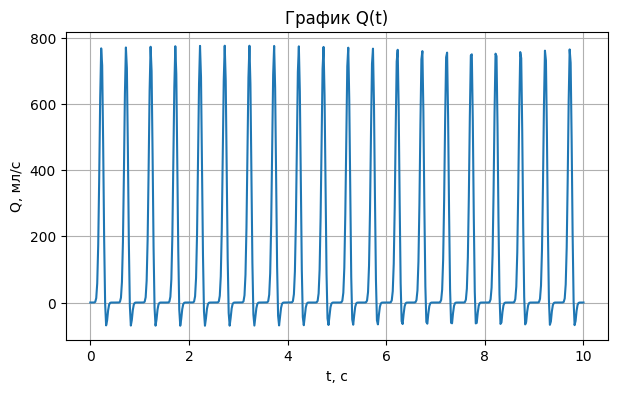

In [10]:
plt.figure(figsize=[7, 4])
plt.plot(t, Q)
plt.xlabel('t, с')
plt.ylabel('Q, мл/с')
plt.title('График Q(t)')
plt.grid(True)

График давления выглядит следующим образом:

In [11]:
P = calcP_WK2(N, Pout, R, C, Q, dt)

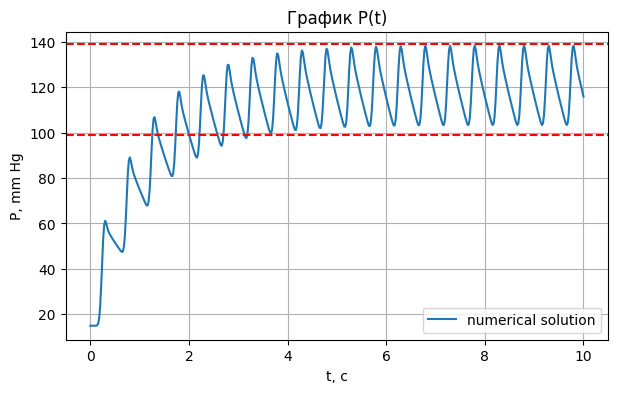

In [12]:
plt.figure(figsize=[7, 4])
plt.plot(t, P, label='numerical solution')
plt.xlabel('t, с')
plt.ylabel('P, mm Hg')
plt.title('График P(t)')
plt.axhline(y = 99, color='r', linestyle='--')
plt.axhline(y = 139, color='r', linestyle='--')
plt.grid(True)
plt.legend()

Как видно на рисунке, исходя из начальных условий, наша модель будет обладать нормальным давлением.\
В качестве дальнейшего шага нужно решим уравнение, используя [метод Рунге-Кутты 5(4) порядка](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html), точность которого гораздо выше точности метода Эйлера:

In [13]:
def windkessel_2el_model(t, y, SV, T, n, phi, Pout, C, R, N):
    Q = getQ(SV, T, t, n, phi, N)
    return Q / C - (y - Pout) / (C * R)

In [14]:
sol = solve_ivp(windkessel_2el_model, t_span=[0, 10], y0=[Pout], method='RK45', args=(SV, T, n, phi, Pout, C, R, N), max_step=dt)

C:\Users\BOBR\AppData\Local\Temp\ipykernel_15624\646884143.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 1 / w * np.trapz(np.sin(t) ** n * np.cos(t - phi), x=t)


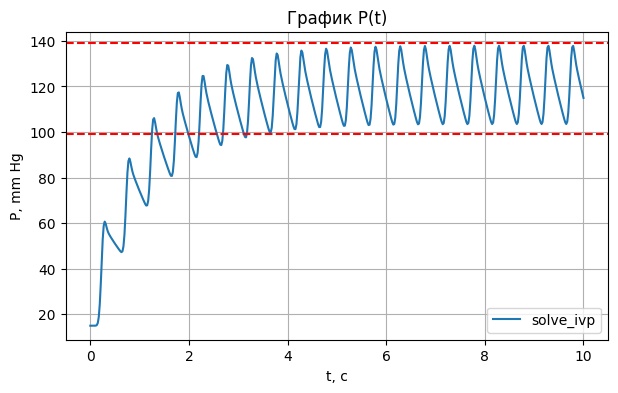

In [15]:
plt.figure(figsize=[7, 4])
plt.plot(sol.t, sol.y[0], label='solve_ivp')
plt.xlabel('t, с')
plt.ylabel('P, mm Hg')
plt.title('График P(t)')
plt.axhline(y = 99, color='r', linestyle='--')
plt.axhline(y = 139, color='r', linestyle='--')
plt.grid(True)
plt.legend()

Для того, чтобы посмотреть на точность численного решения методом Эйлера относительно метода Рунге-Кутты используем метрику MAE ([mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error)) и MAPE([mean absolute percentage error
](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)):
\begin{equation}
MAE(y_{true}, y_{ppred}) = \frac{1}{N}\sum_{i=1}^{N}|y_i-f(x_i)| \qquad MAPE(y_{true}, y_{ppred}) = \frac{1}{N}\sum_{i=1}^{N}|\frac{y_i-f(x_i)}{y_i}|
\end{equation}


Разница между методом Эйлера и методом Рунге-Кутты 5(4) порядка: 
MAE = 0.9918641586730033, MAPE = 0.013790663587921661 


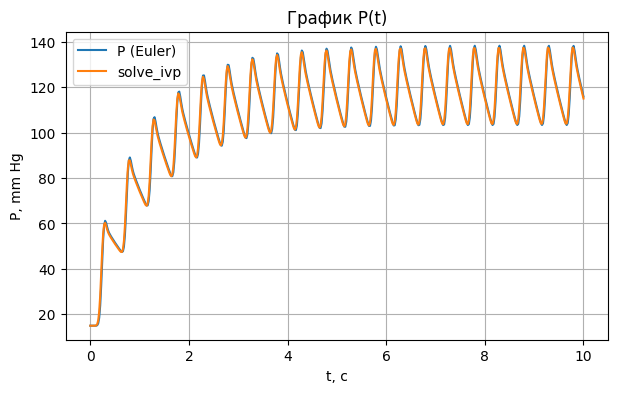

In [16]:
P_ivp = np.interp(t, sol.t, sol.y[0])
print(f'Разница между методом Эйлера и методом Рунге-Кутты 5(4) порядка: \nMAE = {MAE(P_ivp, P)}, MAPE = {MAPE(P_ivp, P)} ')

plt.figure(figsize=[7, 4])
plt.plot(t, P, label='P (Euler)')
plt.plot(t, P_ivp, label='solve_ivp')
plt.xlabel('t, с')
plt.ylabel('P, mm Hg')
plt.title('График P(t)')
plt.grid(True)
plt.legend()
plt.show()

Исходя из значений MAE и MAPE можем сделать вывод о том, что разница между двумя этими методами мнимальна. По этой причине использование более точных методов нецелесообразна

## 4 – element Windkessel model

4-el Windkessel является более сложной и точной моделью по сравнению с двухэлементными моделями. Она включает в себя четыре параметра: сопротивление (R2), комплаенс (C), инерцию (L) и дополнительное сопротивление (R1), которое может представлять характеристическое сопротивление. \
Применение модели 4-el Windkessel:
1.	Более точное моделирование артериального давления и кровотока:\
•	Модель 4-el Windkessel позволяет более точно моделировать динамику артериального давления и кровотока, учитывая инерцию кровотока и характеристическое сопротивление.
2.	Моделирование различных патологий:\
•	Модель позволяет моделировать различные патологии, такие как гипертензия, гипотензия, атеросклероз и сердечная недостаточность, изменяя параметры R1, R2, C и L.
3.	Исследование влияния инерции кровотока:\
•	Модель позволяет исследовать, как инерция кровотока влияет на артериальное давление и кровоток, что может быть важно для понимания механизмов некоторых сердечно-сосудистых заболеваний.

Уравнение для модели 4-el Windkessel можно записать следующим образом:
\begin{equation}
(1+\frac{R_1}{R_2})Q(t)+(R_1C+\frac{L}{R_2})\frac{dQ(t)}{dt}+LC\frac{d^{2}Q(t)}{dt^{2}}=\frac{P(t)}{R_2}+C\frac{dP(t)}{dt}
\end{equation}
где:\
    •	Q(t) — кровоток (аналог тока в электрической цепи),\
    •	P(t) — артериальное давление (аналог напряжения в электрической цепи),\
    •	R1 — характеристическое сопротивление,\
    •	R2 — периферическое сопротивление,\
    •	C — комплаенс,\
    •	L — инерция.



In [17]:
def calcP_WK4(N, Pout, R1, R2, C, L, Q, dQ, d2Q, dt):
    P = np.zeros(N)
    P[0] = Pout  

    for i in range(N - 1):
        P[i + 1] = P[i] + dt * ((1 + R1/R2) * Q[i] + (C*R1 + L/R2)* dQ[i] + L*C * d2Q[i] - (P[i] - Pout) / R2) / C
    return P

Зададим начальные условия:

In [18]:
R1 = 128e-5
R2 = 0.6
L = 145e-5
C = 1.5
SV = 65
Pout = 40

In [19]:
T = 1.0 
n = 13
phi = np.pi / 10
t_start = 0
t_finish = 10
N = 500
dt = (t_finish - t_start) / (N - 1)
t = np.linspace(t_start, t_finish, N)

In [20]:
Q = np.zeros(N)
for i in range(N):
    Q[i] = getQ(SV, T, t[i], n, phi, N)

dQ = np.zeros(N)
for i in range(N-1):
    dQ[i] = getdQ(SV, T, t[i], n, phi, N)

d2Q = np.zeros(N)
for i in range(N-1):
    d2Q[i] = getd2Q(SV, T, t[i], n, phi, N)

C:\Users\BOBR\AppData\Local\Temp\ipykernel_15624\646884143.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 1 / w * np.trapz(np.sin(t) ** n * np.cos(t - phi), x=t)


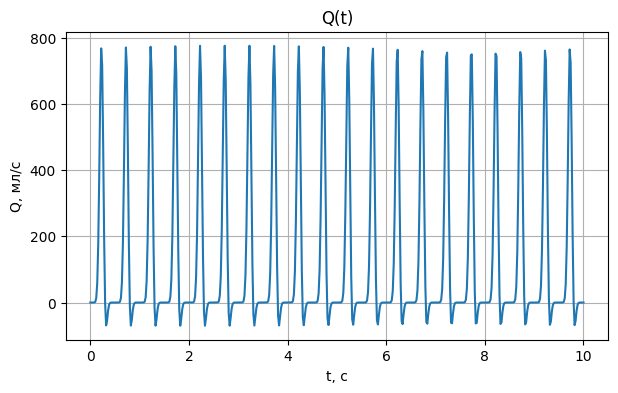

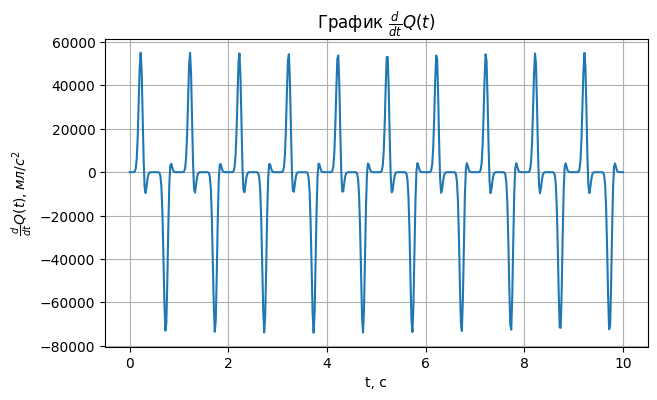

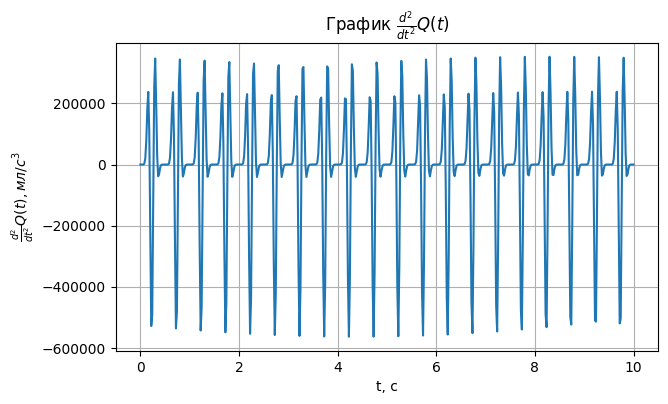

In [21]:
plt.figure(figsize=[7, 4])
plt.plot(t, Q)
plt.xlabel('t, с')
plt.ylabel('Q, мл/с')
plt.title('Q(t)')
plt.grid(True)
plt.show()

plt.figure(figsize=[7, 4])
plt.plot(t, dQ)
plt.xlabel('t, с')
plt.ylabel(r'$\frac{d}{dt}Q(t), мл/с^{2}$')
plt.title(r'График $\frac{d}{dt}Q(t)$')
plt.grid(True)
plt.show()

plt.figure(figsize=[7, 4])
plt.plot(t, d2Q)
plt.xlabel('t, с')
plt.ylabel(r'$\frac{d^2}{dt^2}Q(t), мл/с^{3}$')
plt.title(r'График $\frac{d^2}{dt^2}Q(t)$')
plt.grid(True)
plt.show()

In [22]:
P = calcP_WK4(N, Pout, R1, R2, C, L, Q, dQ, d2Q, dt) 

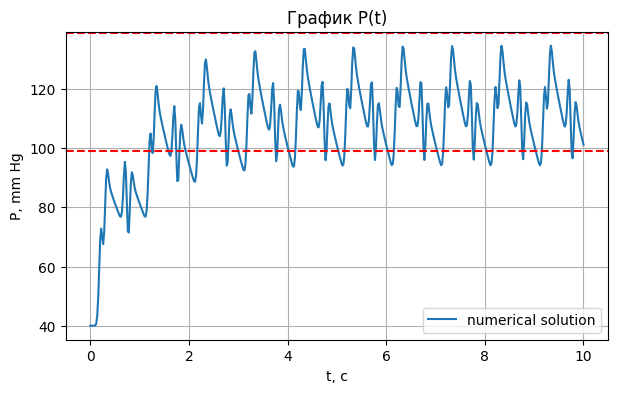

In [23]:
plt.figure(figsize=[7, 4])
plt.plot(t, P, label='numerical solution')
plt.xlabel('t, c')
plt.ylabel('P, mm Hg')
plt.axhline(y = 99, color='r', linestyle='--')
plt.axhline(y = 139, color='r', linestyle='--')
plt.title('График P(t)')
plt.grid(True)
plt.legend()

In [24]:
def windkessel_4el_model(t, y, SV, T, n, phi, Pout, R1, R2, C, L, N): 
    Q = getQ(SV, T, t, n, phi, N)
    dQ = getdQ(SV, T, t, n, phi, N)
    d2Q = getd2Q(SV, T, t, n, phi, N)
    return ((1 + R1/R2) * Q + (C*R1 + L/R2)* dQ + L*C * d2Q - (y - Pout) / R2) / C

In [25]:
sol = solve_ivp(windkessel_4el_model, t_span=[0, 10], y0=[Pout], method='RK45', args=(SV, T, n, phi, Pout, R1, R2, C, L, N), max_step=dt)

C:\Users\BOBR\AppData\Local\Temp\ipykernel_15624\646884143.py:3: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 1 / w * np.trapz(np.sin(t) ** n * np.cos(t - phi), x=t)


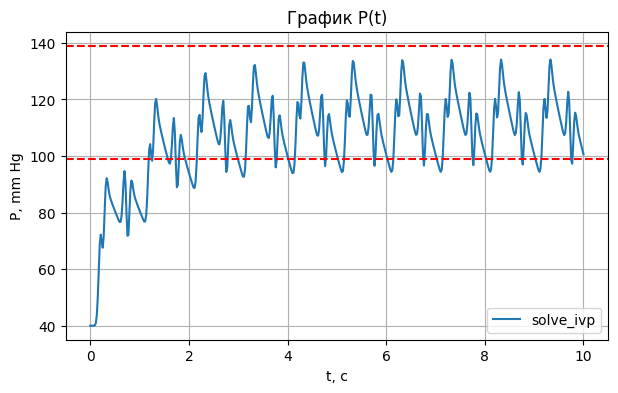

In [26]:
plt.figure(figsize=[7, 4])
plt.plot(sol.t, sol.y[0], label='solve_ivp')
plt.xlabel('t, c')
plt.ylabel('P, mm Hg')
plt.title('График P(t)')
plt.axhline(y = 99, color='r', linestyle='--')
plt.axhline(y = 139, color='r', linestyle='--')
plt.grid(True)
plt.legend()

Difference between Euler and solve_ivp solutions: 
MAE = 1.0352270505272116, MAPE = 0.015551436948297857 


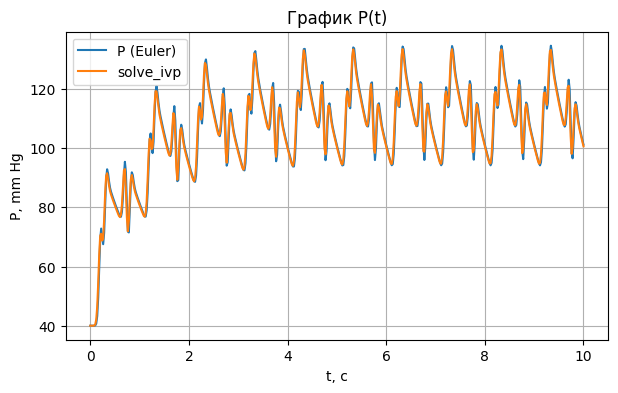

In [27]:
P_ivp = np.interp(t, sol.t, sol.y[0])
print(f'Difference between Euler and solve_ivp solutions: \nMAE = {MAE(P_ivp, P)}, MAPE = {MAPE(P_ivp, P)} ')

plt.figure(figsize=[7, 4])
plt.plot(t, P, label='P (Euler)')
plt.plot(t, P_ivp, label='solve_ivp')
plt.xlabel('t, c')
plt.ylabel('P, mm Hg')
plt.title('График P(t)')
plt.grid(True)
plt.legend()
plt.show()

## Примеры патологий

1.	Гипертензия (повышенное артериальное давление): \
•	Увеличение R2: Повышенное периферическое сопротивление увеличивает артериальное давление. \
•	Уменьшение C: Снижение эластичности артерий также способствует повышению давления.

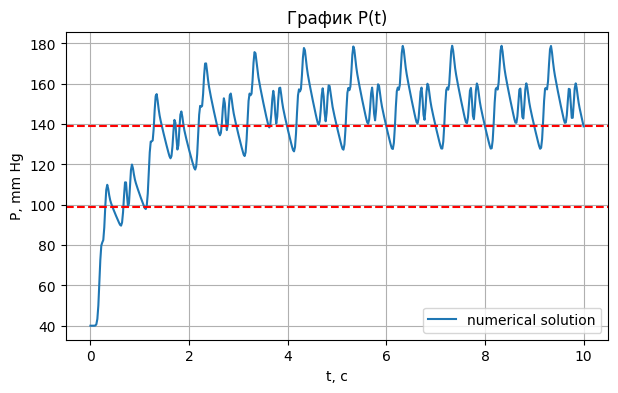

In [28]:
P = calcP_WK4(N, Pout, R1, R2 *1.5, C*0.7, L, Q, dQ, d2Q, dt) 
plt.figure(figsize=[7, 4])
plt.plot(t, P, label='numerical solution')
plt.xlabel('t, c')
plt.ylabel('P, mm Hg')
plt.axhline(y = 99, color='r', linestyle='--')
plt.axhline(y = 139, color='r', linestyle='--')
plt.title('График P(t)')
plt.grid(True)
plt.legend()

2.	Гипотензия (пониженное артериальное давление): \
•	Уменьшение R2: Снижение периферического сопротивления приводит к понижению артериального давления. \
•	Увеличение C: Увеличение эластичности артерий может способствовать снижению давления.

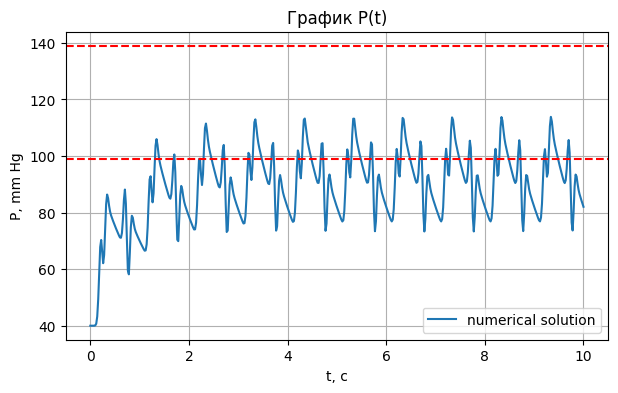

In [29]:
P = calcP_WK4(N, Pout, R1, R2 * 0.75, C*1.2, L, Q, dQ, d2Q, dt) 
plt.figure(figsize=[7, 4])
plt.plot(t, P, label='numerical solution')
plt.xlabel('t, c')
plt.ylabel('P, mm Hg')
plt.axhline(y = 99, color='r', linestyle='--')
plt.axhline(y = 139, color='r', linestyle='--')
plt.title('График P(t)')
plt.grid(True)
plt.legend()

In [30]:
# YOUR CODE